In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Apr 11 13:05:16 2022

@author: bened
"""

import os

# Set working directory to where PyLMDI module is located
os.chdir(r"C:\Users\bened\OneDrive - Norwegian University of Life Sciences\Fag\Masteroppgave\Python stuff\PyLMDI")

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# Import PyLMDI function
from PyLMDI import PyLMDI

# Set directory back to working directory
os.chdir(r"C:\Users\bened\OneDrive - Norwegian University of Life Sciences\Fag\Masteroppgave\Python stuff\Functions")


# Supplementary functions

### Df to nested dict function

In [2]:

def df_to_nested_dict(df):
    
    #create unique list of sectors
    sectors = df.næring.unique()
    
    #create a data frame dictionary to store your data frames
    dfd = {elem : pd.DataFrame for elem in sectors}
    
    # Create nested dict where each dataframe containing sector number is key
    for key in dfd.keys():
        dfd[key] = df[:][df.næring == key]
        
    return dfd # dict containing dataframes

The df_to_nested_dict function stores sector names in master dataframe as key and then appends the data relevant to each sector for its respective key.

### Rename years and shift function

In [3]:
def rename_shift_func(df):
    
    """
    Shifts year by -1 (90 becomes 91) in results column
    
    Reason for shifting year by -1:
        When doing the LMDI analysis the result is the difference between t and t+1.
        First year in data is 1990, hence first result year is 1991 and last year is 2020
    """
    
    df = df.reset_index()
    df = df.rename(columns={'index': 'year'})
    year = df['year'].shift(-1).fillna(2019).astype('int')
    df['year'] = year
    df = df.set_index('year')
    
    return df

### Identity assurance function

In [4]:
def identity_assurance_func(df):
    
    """
    Input: Dataframe with factors ready for composition
    Operation: 
        Calculates difference between product of factors and emissions
    Returns: 
        If residual column is 0, returns dataframe ready for decomposition
    """
    
    factors = ['totGDP', 'secGDP_totGDP', 'GWh_gdp', 'fossGWh_totGWh',
           'mtCO2e_fossGWh']
    
    df['res'] = df['mtCO2e'] - df[factors].prod(axis=1).round(2) # round to eliminate rounding errors
    
    # Assert that residuals are 0
    if df['res'].sum() == 0:
        return df
    
    else:
        return print('Factors are not equal to emissions')

The LMDI-IDA method needs factors to form an identity in order to yield results without a residual. The identity assurance function checks that the sum of the factors is equal to emissions. I.e. that the identity assumption holds.

This is fundamentaly done by checking that the sum of the residual column equals 0.

### Nested dict to dataframe function

This function turns a nested dictionary with many dataframes into a single dataframe. This is necessary for the plotting functions further down in the script to work.

In [5]:
def nested_dict_to_df(n_dict):
    
    """
    Input: Nested dict with results
    Output: Dataframe with drivers as columns, sectors as index
    
    """
    
    # Make dataframe from nested dict
    df = pd.concat({k: pd.DataFrame(v).T for k, v in n_dict.items()}, axis=1)
    
    # Drop multilevel columns
    df.columns = df.columns.droplevel()
    
    # reset index, tranpose dataframe
    df = df.reset_index().transpose()
    
    # set factors as column headers
    df.columns = df.iloc[0]
    
    # remove row containing column names, make dataframe into float
    df = df.iloc[1: , :].astype('float')
    
    # Redefine column order
    df = df[['totGDP', 'sec_gdp/totGDP', 'totGWh/sec_gdp', 'fossGWh/totGWh', 'mtCO2e/fossGWh']]
    
    return df



### Aggregate results function

Aggregates results per driver across sectors, then commits to separate dataframe. This is necessary to calculate the total effect per factor affecting emissions across the economy

In [6]:

# Function for summing results per sector - sum of all years in order to get total change
def result_sum_func(n_dict):
    
    """
    Input: Nested dict with chained results from LMDI-IDA
    Output: Nested dict with sum of contribution from drivers
    
    """
    
    # Pull out sector names in dictionary
    sectors = list(n_dict.keys())
    
    # Create place to store results
    d_sum = {}
    
    # Define loop integer
    i = 0
    
    # Summing loop
    for k in n_dict:
    
        d_sum[k] = pd.DataFrame(n_dict[k].sum())                                # sums contribution for each driver within results
        d_sum[k]['sector'] = sectors[i]                                         # adds corresponding sector as column in dataframe
        d_sum[k]['factor'] = d_sum[k].index                                     # makes factors into column
        d_sum[k] = d_sum[k].pivot(columns='factor', values=0, index = 'sector') # pivots result dataframe into pretty format
        
        i += 1
    
    return d_sum

### LMDI object

In [7]:
class LMDI_machine_agg():
    
    
    def __init__(self, df, year, mode):
       
        """
        Takes drivers, and finds out how much each driver affects mtCO2e emissions
        Yields results in either absolute numbers, or as % effect on emissions.
        Individual columns in dataframe is interpreted as driving factor
        Currently suited for 5 factors +  emissions column
        
        Inputs:
            df = dataframe
            year = int indicating start year of analysis
            mode = string indicating mode of decomposition. Must be set to 'add' or 'mul'.
                add = additive decomposition
                mul = multiplicative decomposition
        
        Input order:
            "totGDP"           : ans[1],           
            "sec_gdp/totGDP"   : ans[2],           
            "totGWh/sec_gdp"    : ans[3],           
            "fossGWh/totGWh"    : ans[4],           
            "mtCO2e/fossGWh"    : ans[5]    
        
        Output:
            df with absolute or %-effect on emissions in time period

        """
        
        self.df0 = df.set_index(['år'])
        self.df1 = df.shift(-1).dropna().set_index(['år'])
        self.year0 = year
        self.year1 = year + 1
        self.mode = mode
        self.drivers = list(self.df0.loc[:, self.df0.columns != 'mtCO2e']) # Every column except mtCO2e
    
    def LMDI_decomposer_agg(self):
        
        # Emissions for t and t+1
        C0 = list(self.df0['mtCO2e'].loc[self.df0.index == self.year0]) # emissions for t0
        Ct = list(self.df1['mtCO2e'].loc[self.df1.index == self.year1]) # emissions for t+1

        # define drivers of emissions for t and t+1
        factors0 = self.df0[self.drivers].loc[self.df0.index == self.year0]  # drivers in t0
        factors1 = self.df1[self.drivers].loc[self.df1.index == self.year1]  # drivers for t+1
    
        # Reshape drivers of emissions for t and t+1 to vertical np.arrays
        X0 = np.array(factors0).reshape([-1,1])
        Xt = np.array(factors1).reshape([-1,1])
        
        # LMDI additive decomposer function
        LMDI = PyLMDI(Ct,C0,Xt,X0)
        ans = []
        
        try:
            if self.mode == 'add':
                ans = LMDI.Add() # Additive decomposition
            
            elif self.mode == 'mul':
                ans = LMDI.Mul() # Multiplicative decomposition
                
        except:
            print('Mode must be set to either additive (keyword: add) or multiplicative (keyword: mul) decomposition')
        
        results = {}
        results = {
            "totGDP"           : ans[1],   # contributions from overal activity in the economy
            "sec_gdp/totGDP"   : ans[2],   # contributions from ratio of subsector gdp/sector gdp (sector structure)
            "totGWh/sec_gdp"    : ans[3],  # contributions from energy efficiency per unit of GDP
            "fossGWh/totGWh"    : ans[4],  # contributions from efficiency of fossil energy
            "mtCO2e/fossGWh"    : ans[5]   # contributions from efficiency of carbon emissions per unit of fossil energy           
            }
        
        return results

The above class does the actual work of the LMDI analysis. It does however only run analaysis between two rows of data. I.e. it cannot provide results over an entire dataframe or nested dict with dataframes inside. To solve this problem, the LMDI_analysis class below was created. This object triggers the LMDI_Machine_agg class for each row present in dataframe provided. Thus, it's able to loop over an entire dataframe with the class above.

In [8]:
class LMDI_analysis():

    def __init__(self, df, start, stop, mode):
        
        self.df = df
        self.start = start
        self.stop = stop
        self.mode = mode
        
    def LMDI_analysis_func_v3(self):
        
        """
        What it does:
            Runs the LMDI_machine and subsequent decomposer n times and stores results in a dataframe
        
        Inputs:
            df = dataframe
            start = int indicating start year of chained decomposition
            stop = int indicating stop year
            mode = str 'add' or 'mul' indicating additive or multiplicative decomposition
            
        Process:
            Creates cloned dataframe and shifts data back one step
            Concatenates original and cloned dataframe
            Creates empty list to store results in
            Runs the LMDI chained decomposer function from start to stop
            Appends results for each year to dataframe
            
        Output:
            Nested dictionary with dataframes containing results
        
        """
        
        try:
            
            # Define empty list to store results in
            res = []
        
            # Run loop with additive LMDI for the years 1990 - 2020. Yields chained results 
            for years in list(range(self.start, self.stop)):
                res.append(LMDI_machine_agg(self.df, years, self.mode).LMDI_decomposer_agg()) # appends results from each year to list
                
                years += 1
                
            #Add results to dataframe
            result = pd.DataFrame(res[0:],columns=res[0])
            result.index = list(range(self.start, self.stop))
            
            return result
        
        except:
            
            print('Dataframe must be of type dataframe, start and stop must be of type int. Start and stop cannot be longer than the dataframe, mode must be of type str. Df must be called df')



# Scripting of data and analysis

In [9]:
# Dekstop
df = pd.read_csv(r"C:\Users\bened\OneDrive - Norwegian University of Life Sciences\Fag\Masteroppgave\Data\Ferdige_data\LMDI_ready\sektor_kaya.csv")

#Display variables in raw data, agg_næring indicates which sector data belongs to
df.info()

# Apply identity assurance function
df = df.pipe(identity_assurance_func)

# Rename columns
df = df.rename(columns={'agg_næring' : 'næring', 'secGDP_totGDP': 'secGDP/totGDP'})

# Make nested dict of dataframes with næring as key
dfd_agg = df_to_nested_dict(df)

print()
print('Sectors present in nested dictionary:')
print(dfd_agg.keys())

print()
print('A look inside one of the dataframes within dfd_agg:')
# A look inside one of the nested dictionaries
dfd_agg['Industri'].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   agg_næring      300 non-null    object 
 1   år              300 non-null    int64  
 2   totGDP          300 non-null    float64
 3   secGDP_totGDP   300 non-null    float64
 4   GWh_gdp         300 non-null    float64
 5   fossGWh_totGWh  300 non-null    float64
 6   mtCO2e_fossGWh  300 non-null    float64
 7   mtCO2e          300 non-null    float64
 8   res             300 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 21.2+ KB

Sectors present in nested dictionary:
dict_keys(['Jordbruk, skogbruk og fiske', 'Bergverksdrift og utvinning av råolje og naturgass, inkl. tjenester', 'Industri', 'Energi- og vannforsyning, avløp og renovasjon', 'Bygge- og anleggsvirksomhet', 'Varehandel, rep. av motorvogner, overnatting og servering', 'Andre tjenesteytende næringer', 

,næring,år,totGDP,secGDP/totGDP,GWh_gdp,fossGWh_totGWh,mtCO2e_fossGWh,mtCO2e,res
60,Industri,1990,1776729.0,0.098590,1.480907,2.209640,0.035224,20190.0,0.0
61,Industri,1991,1781787.0,0.096202,1.441839,2.229285,0.033668,18550.0,0.0
62,Industri,1992,1833320.0,0.094748,1.536916,2.227178,0.027503,16353.0,0.0
63,Industri,1993,1857118.0,0.094312,1.540863,2.239800,0.028449,17197.0,0.0
64,Industri,1994,1961089.0,0.090635,1.580675,2.248752,0.028661,18108.0,0.0


### Running the LMDI analysis function object

LMDI_analysis object and subsequent LMDI analysis function runs LMDI analysis and stores results for each dataframe in nested dictionary. Results of aggregate changes acrros the economy and per sectors are then commited separately

In [10]:
# Create dict to store multiplicative results
res_agg_mul = {}

# Create dict to store additive results
res_agg_add = {}

# Define column list for dicts
col_list = ['år', 'totGDP', 'secGDP/totGDP', 'GWh_gdp', 'fossGWh_totGWh',
       'mtCO2e_fossGWh', 'mtCO2e']

# Get additive results, store to nested dict
for k in dfd_agg:
    res_agg_add[k] = dfd_agg[k][col_list]
    res_agg_add[k] = LMDI_analysis(res_agg_add[k], 1990, 2019, 'add').LMDI_analysis_func_v3()

"""
Results: Chained additive and multiplicative LMDI-IDA results for 1991 to 2019
Years in results dataframes are incorrectly shown due to how LMDI analysis objects work
This is fixed in the next section

"""

# Shift indexes in nested dataframes by 1 year by applying function
for k in res_agg_mul:
    res_agg_add[k] = res_agg_add[k].pipe(rename_shift_func)

# Get additive results in nested dict, with correct years
sum_add =  result_sum_func(res_agg_add)

print('A look inside one of the aggregate result dataframes')
print(sum_add['Industri'].head())

# Take additive results, turn from nested dict to dataframe
result_add = nested_dict_to_df(sum_add)

print()
print('A look inside one of the sector result dataframes')
print(result_add.head())


A look inside one of the aggregate result dataframes
factor    fossGWh/totGWh  mtCO2e/fossGWh  sec_gdp/totGDP     totGDP  \
sector                                                                
Industri      1593.57798   -13215.236844    -4857.519326  8058.8264   

factor    totGWh/sec_gdp  
sector                    
Industri       145.35179  

A look inside one of the sector result dataframes
factor                                                   totGDP  \
sector                                                            
Jordbruk, skogbruk og fiske                         2974.012979   
Bergverksdrift og utvinning av råolje og naturg...  6699.049522   
Industri                                            8058.826400   
Energi- og vannforsyning, avløp og renovasjon       1318.853359   
Bygge- og anleggsvirksomhet                          826.579518   

factor                                              sec_gdp/totGDP  \
sector                                                       

### Testing of results

In [11]:
# Get additive results
test = res_agg_add

# Add differenced emissons to results (change in emissions)
for k in dfd_agg:
    test[k]['mtCO2e'] = dfd_agg[k].set_index('år')['mtCO2e']
    test[k]['mtCO2e_d'] = test[k]['mtCO2e'].diff(1)


# Make dataframe from nested dict
em = pd.concat({k: pd.DataFrame(v).T for k, v in test.items()}, axis=1)

# reset index, tranpose dataframe
em = em.reset_index().transpose()

# set factors as column headers
em.columns = em.iloc[0]

# Drop first row
em = em.iloc[1: , :]

# # Drop sector column, turn into float
em = em.astype('float').dropna()

# Add up factors, see if they are the same as differenced emissions
em['res'] = em['mtCO2e_d'] - em.iloc[:, 0:5].sum(axis=1).round(2)

# Create additive drivers aggregate columns -> yields total effect across sectors
add_agg = pd.DataFrame(em.iloc[:,0:5].sum()).transpose()


# Plotting of results

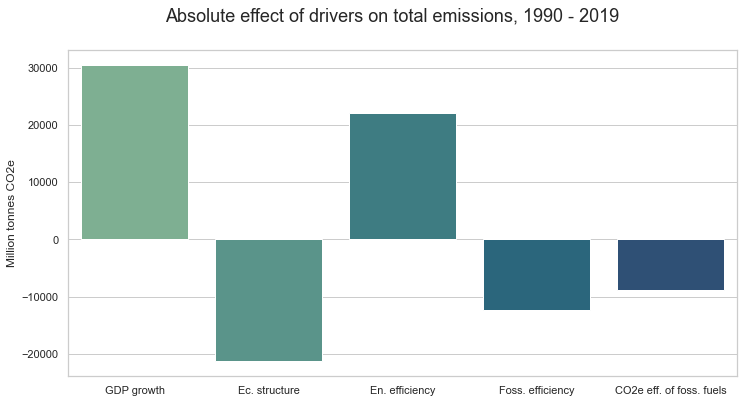

In [12]:
"""
Define lists of drivers and english sectors for plots
"""

# Labels drivers
factors = ['GDP growth', 'Ec. structure'
                 , 'En. efficiency'
                 , 'Foss. efficiency'
                 , 'CO2e eff. of foss. fuels'
                 , 'Total Emissions Change']


# Labels for sectors in english
sectors = ['Agri- & aquaculture and forestry '
                 ,'Mining and petroleum'
                 , 'Industry'
                 , 'Energy, water, sewage and waste management'
                 , 'Construction'
                 , 'Retail & hospitality'
                 , 'Other services'
                 , 'Transport'
                 , 'Education, healthcare and social services'
                 , 'Public administration and defence'] 

# Change sector names to english
result_add.index = sectors

def barplot_additive_aggregate(df, factors):
    
    sns.set(style='whitegrid', rc = {'figure.figsize':(12,6)}) # need to set size
    plot = sns.barplot(data = df, palette='crest')
    # plot.bar_label(plot.containers[0])
    plot.set(ylabel ='Million tonnes CO2e')
    #plt.legend(factors)
    plt.suptitle('Absolute effect of drivers on total emissions, 1990 - 2019', size = 18)

    plt.show()

# Change drivers to english
add_agg.columns = ['GDP growth', 'Ec. structure'
                 , 'En. efficiency'
                 , 'Foss. efficiency'
                 , 'CO2e eff. of foss. fuels']
    
# Apply plot function to results
add_agg.pipe(barplot_additive_aggregate, factors)

plt.close()

### Plotting of effect of drivers across sectors

Index(['totGDP', 'sec_gdp/totGDP', 'totGWh/sec_gdp', 'fossGWh/totGWh',
       'mtCO2e/fossGWh'],
      dtype='object', name='factor')


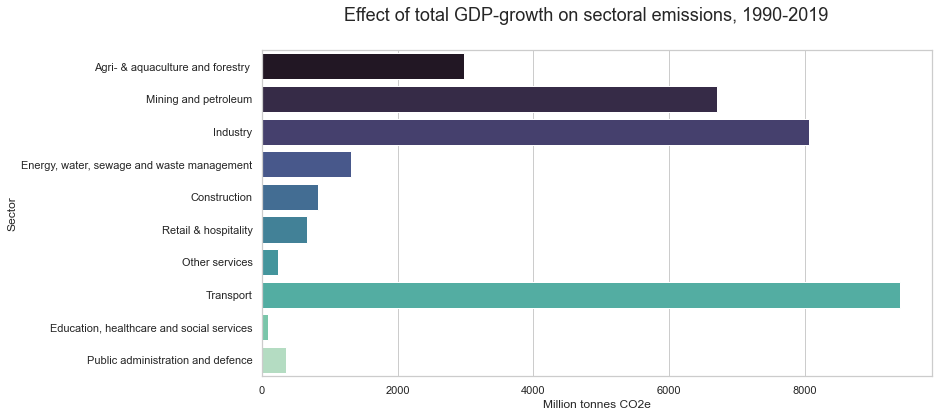

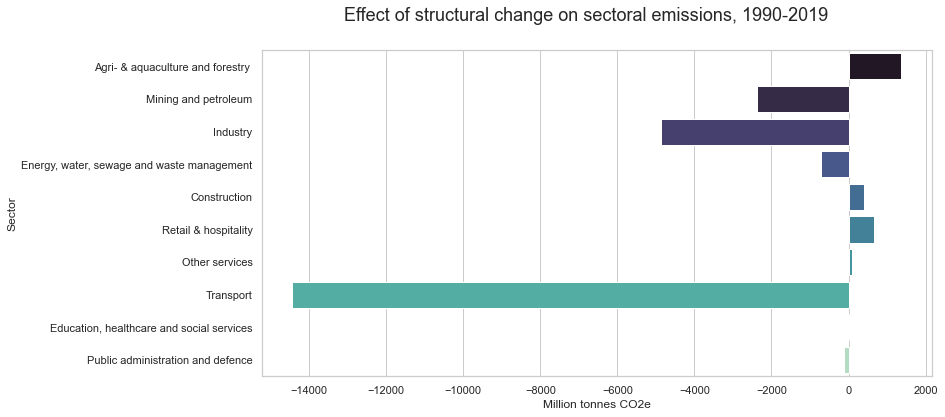

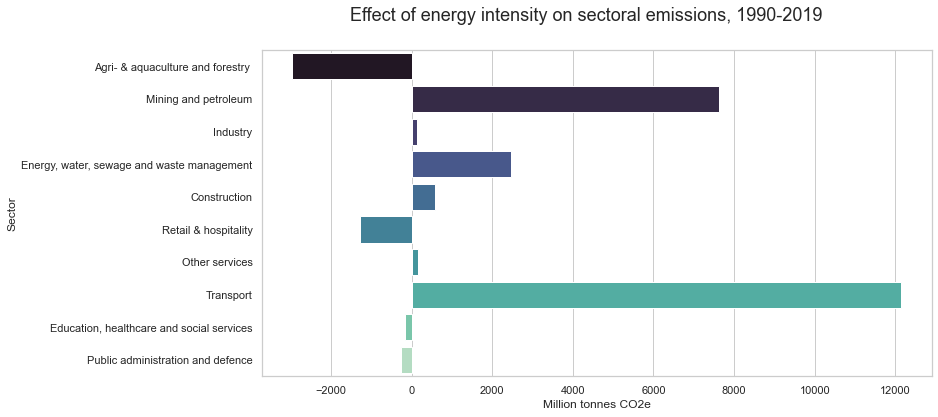

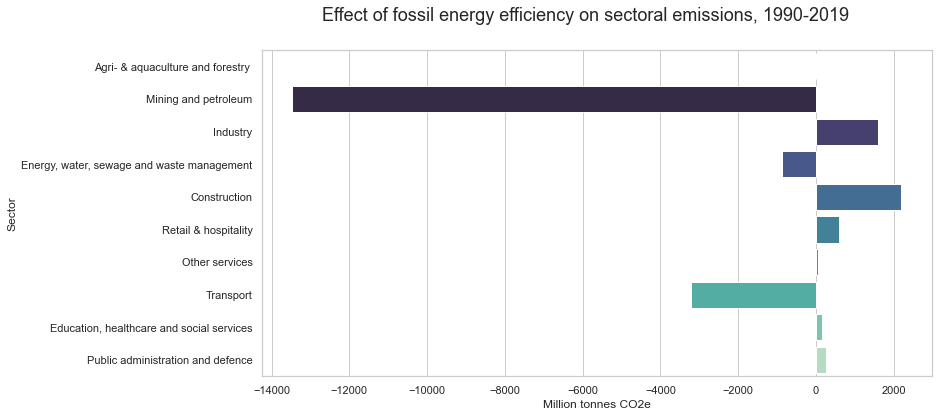

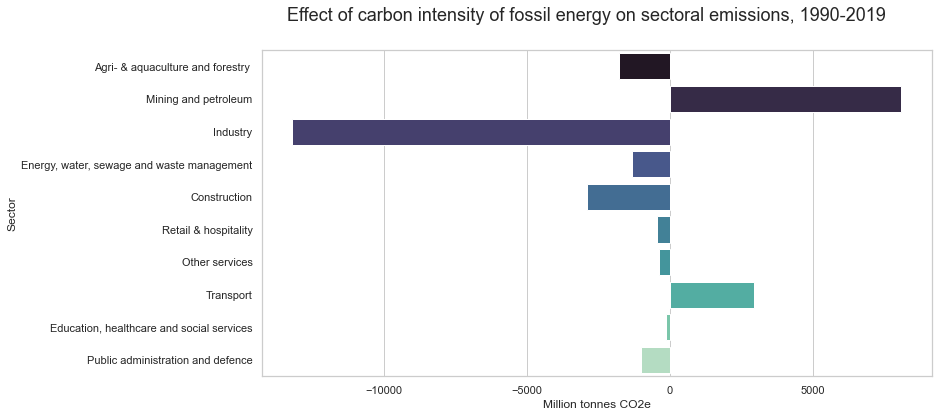

In [13]:
# Define barplotting function
def barplot_additive_drivers(df, sectors, title):
    
    
    df = pd.DataFrame(df)
    sns.set(style='whitegrid', rc = {'figure.figsize':(12,6)}) # need to set size
    plot = sns.barplot(y = df.index, x = df.iloc[:,0], palette='mako')
    # plot.bar_label(plot.containers[0])
    plot.set(ylabel = sectors, xlabel='Million tonnes CO2e')
    # plt.legend(list(df.columns))
    plt.suptitle(title, size = 18)

    plt.show()

print(result_add.columns)
    
# Plot results of economic activity
barplot_additive_drivers(
    result_add['totGDP'], 'Sector', 
    'Effect of total GDP-growth on sectoral emissions, 1990-2019')

# Plot results of structural change
barplot_additive_drivers(
    result_add['sec_gdp/totGDP'], 'Sector', 
    'Effect of structural change on sectoral emissions, 1990-2019')

# Plot results of energy efficiency
barplot_additive_drivers(
    result_add['totGWh/sec_gdp'], 'Sector', 
    'Effect of energy intensity on sectoral emissions, 1990-2019')

# Plot results of fossil energy efficiency
barplot_additive_drivers(
    result_add['fossGWh/totGWh'], 'Sector', 
    'Effect of fossil energy efficiency on sectoral emissions, 1990-2019')

# Plot results of carbon intensity of fossils
barplot_additive_drivers(
    result_add['mtCO2e/fossGWh'], 'Sector', 
    'Effect of carbon intensity of fossil energy on sectoral emissions, 1990-2019')


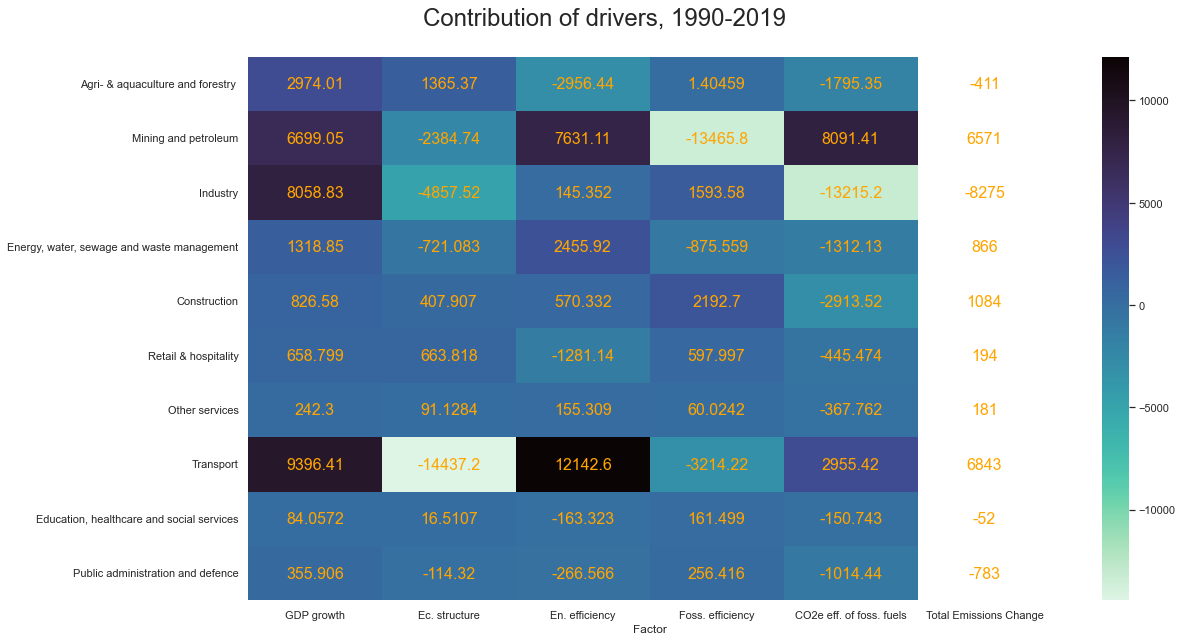

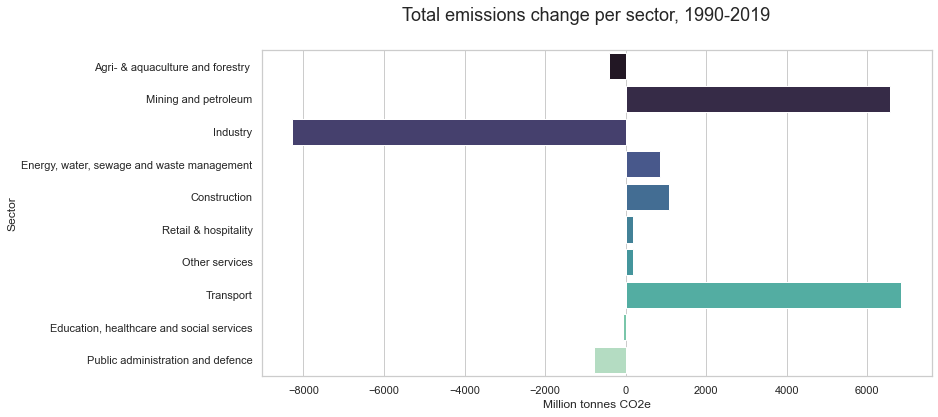

In [14]:
# Heatmapper function for summarising results
def heatmapper_func(df, factors, sectors):
    
    df['total emissions change'] = df.sum(axis=1)
    
    mask = np.zeros((10, 6))
    mask[:,5] = True
    
    sns.set(rc = {'figure.figsize':(18, 10)}, style="whitegrid")
    
    # # Make heatmap of data
    sns.heatmap(df, mask=mask, cbar=True, cmap="mako_r",)
    plt.suptitle('Contribution of drivers, 1990-2019', y=0.95, x=0.4, size =24) # Consider different colour scheme ...blue?
    sns.heatmap(df, alpha=0, cbar=False, annot=True
                , annot_kws={"size": 16, "color":"orange"}, fmt='g',
                xticklabels=factors, yticklabels=sectors)
    plt.xlabel('Factor')

    plt.show()
    
    return df

# Run heatmapper on additive results
heatmapper_func(result_add, factors, sectors)

# Plot results of total emissions change
barplot_additive_drivers(
    result_add['total emissions change'], 'Sector', 
    'Total emissions change per sector, 1990-2019')